In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy import stats
import pyarrow as pa
import pickle


In [4]:
# leer los csv de streaming y ratings y guardarlos en un datframe 
df_ratings = pd.read_csv ("../CSV ETL/df_ratings.csv")
df_streaming = pd.read_csv ("../CSV ETL/df_streaming.csv")

In [5]:
df_streaming_ratings = pd.merge(df_streaming[['id', 'title']], df_ratings[['id','userId','score']], on = "id")

In [6]:
df_streaming_ratings.to_parquet('../CSV ETL/df_streaming_ratings.parquet', compression='snappy')

In [7]:
df_streaming_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11024289 entries, 0 to 11024288
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      object 
 1   title   object 
 2   userId  int64  
 3   score   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 420.5+ MB


El dataframe que nos interesa inicialmente es el de ratings ya que es el que contiene las puntuaciones de los contenidos de las plataformas asignados por los usuarios, y es al que le haremos el EDA.

In [8]:
# ver la cantidad de registros del df
df_ratings.shape

(11024289, 3)

Como se observa el data frame contiene mas de 11 millones de registros, lo que no es muy eficiente ni optimo para nuestro modelo debido a que podria dar cabida a un sobre ajuste del model. Por esta razon es conveniente hacer un muestreo para reducir la cantidad de datos. el tipo de muestreo mas adecuado para el objetivo del proyecto es el muestreo por conglomeracion lo cual no permitira reducir la muestra sin sacrificar la representación de la misma.

dado que los datos no estan jeraquizados lo mejor es agruparlos por usuarios para obtener una muestra representativa de usuarios de las plataformas.

In [9]:
# Dividir los datos en conglomerados según la columna "userId"
conglomerados = df_ratings.groupby('userId')

Una vez que tienes los conglomerados, podemos seleccionar aleatoriamente algunos de ellos para formar la muestra. Para seleccionar aleatoriamente los conglomerados, para ello vamos a utilizar la función np.random.choice() de la librería NumPy.

In [10]:
# Seleccionar aleatoriamente 1000 conglomerados
indices_conglomerados = np.random.choice(len(conglomerados), size=50000, replace=False)

#obtener la muestra representativa del dataframe
muestra = df_ratings.loc[indices_conglomerados]
muestra.shape

(50000, 3)

In [11]:
muestra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 62970 to 35757
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   userId  50000 non-null  int64  
 1   score   50000 non-null  float64
 2   id      50000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


la muestra por conglomerados del df_ratings es de 60.000 registros. ahora vamos a verificar que si sea una muestra representativa al comparar como se comporta con respecto al set completo de datos.

Vamos a comparar la cantidad de usuarios en funcion de la cantidad de contenidos disponibles tanto en la data set completo como en la muestra.

In [12]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

65536 users
22998 items


In [13]:
# 
n_users_muestra = muestra.userId.unique().shape[0]
n_items_muestra = muestra.id.unique().shape[0]
print (str(n_users_muestra) + ' users')
print (str(n_items_muestra) + ' items')

702 users
20358 items


veamos como se comporta el data set y la muestra si vemos la cantidad de usuarios que asiganron una puntuacion especifica.

(array([ 514764.,  167428.,  739955.,  530634., 2233657., 1330338.,
        2971419., 2536094.]),
 array([0.5   , 1.0625, 1.625 , 2.1875, 2.75  , 3.3125, 3.875 , 4.4375,
        5.    ]),
 <BarContainer object of 8 artists>)

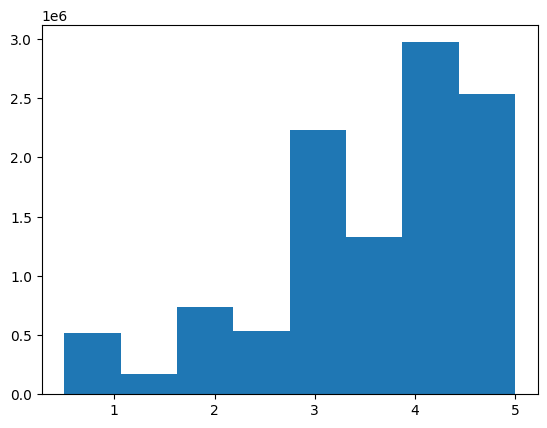

In [14]:
plt.hist(df_ratings.score,bins=8)

In [15]:
df_ratings.groupby(["score"])["userId"].count().sort_values(ascending=False)

score
4.0    2971419
3.0    2233657
5.0    1616526
3.5    1330338
4.5     919568
2.0     739955
2.5     530634
1.0     350589
1.5     167428
0.5     164175
Name: userId, dtype: int64

aqui vemos que en el data set el valor que mas se asigna es el 4.0 y el 3.0 veamos como se comporta la muestra 

(array([ 2014.,   689.,  3976.,  2532., 11175.,  5092., 13537., 10985.]),
 array([0.5   , 1.0625, 1.625 , 2.1875, 2.75  , 3.3125, 3.875 , 4.4375,
        5.    ]),
 <BarContainer object of 8 artists>)

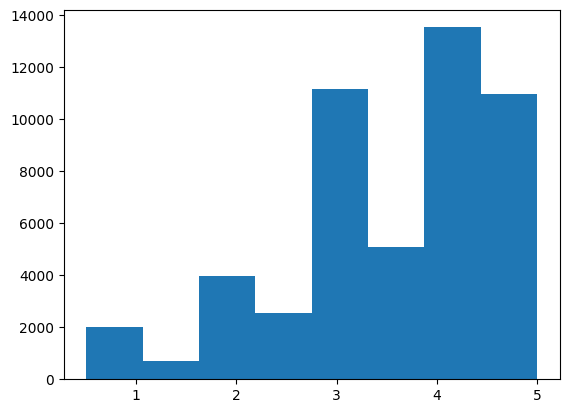

In [16]:
plt.hist(muestra.score,bins=8)

graficamente la muestra se comporta igual que el data set lo cual comprpbamos a continuacion.

In [17]:
muestra.groupby(["score"])["userId"].count().sort_values(ascending=False)

score
4.0    13537
3.0    11175
5.0     7227
3.5     5092
2.0     3976
4.5     3758
2.5     2532
1.0     1505
1.5      689
0.5      509
Name: userId, dtype: int64

In [18]:
print (df_ratings.groupby('userId')['score'].count().std())
print (df_ratings.groupby('userId')['score'].count().mean())

288.83376331538324
168.21730041503906


In [19]:
print(muestra.groupby('userId')['score'].count().std())
print(muestra.groupby('userId')['score'].count().mean())

123.34364760608389
71.22507122507122


<Axes: xlabel='score'>

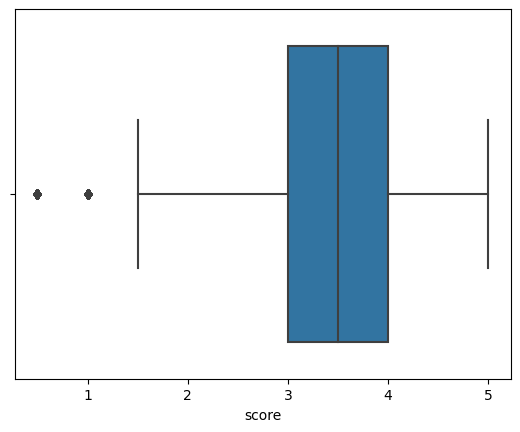

In [20]:
sns.boxplot(x=muestra['score'])

vemos que tanto la muestra como el data set presentan algunos outliers en puntuaciones inferioores a 1.5. sin embargo al tratarse se un cuaestiopn subjetiva de apreciacion no seran eliminados ya que una pelicula o serie le guste a mucha gente no es indicador que no sea del agrado de algunos otros usuarios.

In [21]:
z_scores = stats.zscore(muestra['score'])

In [22]:
threshold = 1.5
outliers = (z_scores < threshold)
muestra[outliers]

,userId,score,id
62970,674,4.5,ns8407
26696,323,3.0,ns3299
38457,425,4.0,ns1106
17947,229,4.0,ns704
30829,353,1.0,as3784
...,...,...,...
31685,360,4.5,hs3015
16554,212,2.5,as343
9799,117,5.0,ns7442
21408,249,3.0,ns5654


vamos ahora a montar nuestro modelo usando la muestra del data set.

In [23]:
#crear la matriz cruzada de usuarios con las peliculas.
df_matrix = pd.pivot_table(muestra, values='score', index='userId', columns='id').fillna(0)
df_matrix

id,as1,as10,as100,as1000,as1002,as1003,as1004,as1005,as1006,as1007,...,ns99,ns990,ns991,ns992,ns993,ns994,ns996,ns997,ns998,ns999
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#ver el porcentaje de esparcimiento 
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.35%


0.35% es el porcentaje que se puede rellenar de la matriz es decir la cantidad de predicciones 

In [25]:
#dividir la muestra en set de entrenamiento y set de testeo.
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(561, 20358)
(141, 20358)


Matriz de Similitud: Distancias por Coseno
Ahora calculamos en una nueva matriz la similitud entre usuarios.

In [26]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(sim_matrix.shape)

(702, 702)


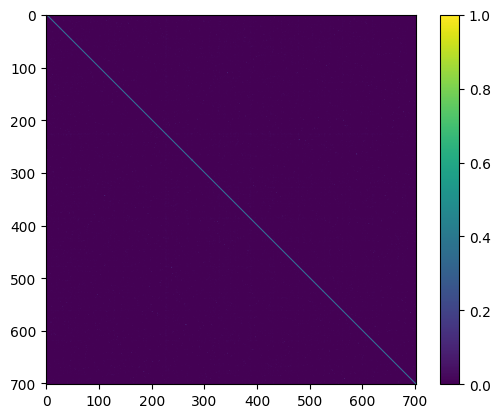

In [27]:
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

Cuanto más cercano a 1, mayor similitud entre esos usuarios

Modelo de "Sugeridos"

In [29]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:561,0:561]
sim_matrix_test = sim_matrix[561:702,561:702]

users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T


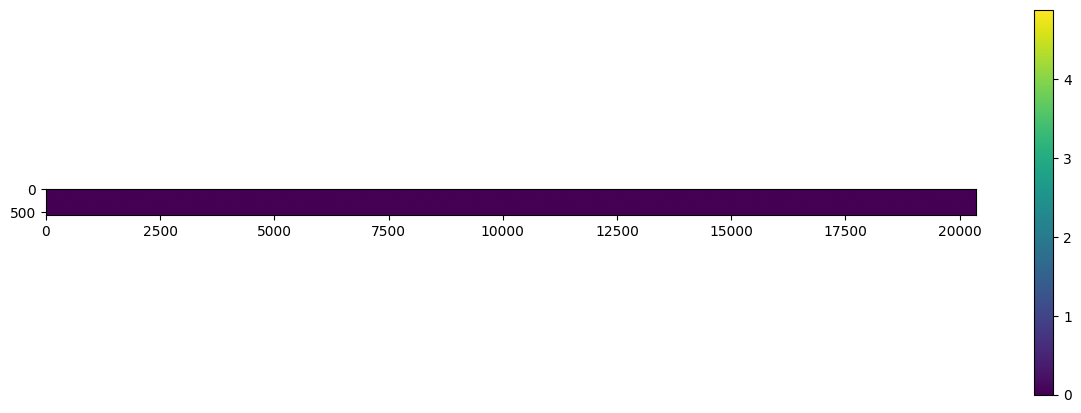

In [30]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [31]:
#USUARIO_EJEMPLO = 'jbagnato'
#data = df_users[df_users['username'] == USUARIO_EJEMPLO]
user_id = 58 # resta 1 para obtener el index de pandas.

user0=users_predictions.argsort()[user_id]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-5:]):
    selRepo = df_streaming[df_streaming['id']==(aRepo+1)]
    registro = df_streaming_ratings.iloc[aRepo,1] 
    print(str(registro)) , 
    

forest fairies
yu-gi-oh! 5d's
yoga to ease flight anxiety
summer '03
resilencia


In [32]:
# Guardar el modelo en un archivo
with open('../users_predictions.pkl', 'wb') as archivo:
    pickle.dump(users_predictions, archivo)

In [33]:
# Cargar el modelo desde un archivo
with open('../users_predictions.pkl', 'rb') as archivo:
    modelo = pickle.load(archivo)